In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

### Load and Display Images

In [2]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [3]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [4]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


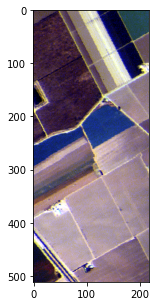

In [5]:
plot_RGB(salinas)

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


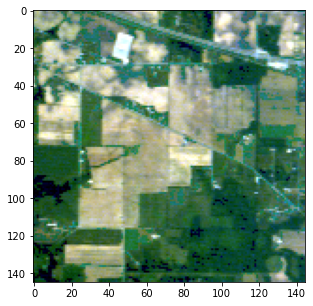

In [6]:
plot_RGB(indiana_pines)

### PCA

In [7]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()
print(X2.shape)
print(Y2.shape)

(111104, 204)
(111104,)
(21025, 200)
(21025,)


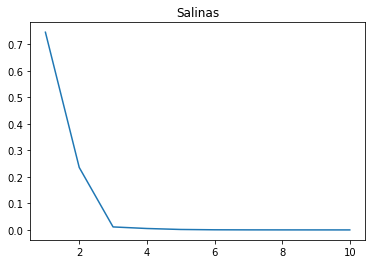

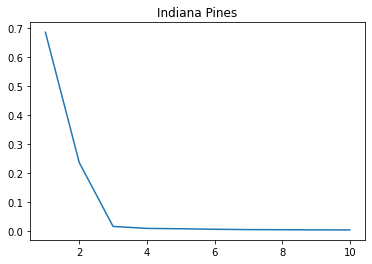

In [8]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")

Variance greater than 0.999: 5


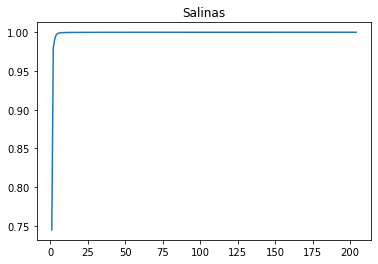

Variance greater than 0.999: 68


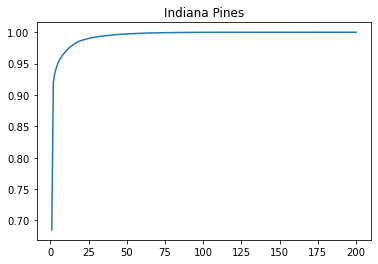

In [9]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.999))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")

In [10]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1)
print(pca1.components_.shape)

X1_pca = pca1.transform(X1)
print(X1_pca.shape)

(20, 204)
(111104, 20)


In [11]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2)
print(pca2.components_.shape)

X2_pca = pca2.transform(X2)
print(X2_pca.shape)

(68, 200)
(21025, 68)


### Classifier

In [12]:
from sklearn import utils

def class_weights(y):
    class_weights = utils.class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(16), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 0.11470872157551042, 1: 3.2531256405001026, 2: 1.7540336585519876, 3: 3.3074541557513695, 4: 4.68832812895603, 5: 2.4404516100689717, 6: 1.650803084557895, 7: 1.826076952155548, 8: 0.5798535544108514, 9: 1.0536078368152033, 10: 1.9937551591716614, 11: 6.11940956157744, 12: 3.3915565188192556, 13: 7.134857436424351, 14: 6.107971412864211, 15: 0.8992197869791835}
{0: 0.11477029564609809, 1: 26.88618925831202, 2: 0.8660817268083704, 3: 1.490077958894401, 4: 5.218416480516257, 5: 2.5605894531725735, 6: 1.6941982272361, 7: 44.17016806722689, 8: 2.5873738616785626, 9: 61.838235294117645, 10: 1.27239167271847, 11: 0.5037738109500419, 12: 2.08560658664815, 13: 6.032998565279771, 14: 0.9776796093931643, 15: 3.2040536421822616}


In [13]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(shuffle=True, early_stopping=True, class_weight=class_weights1, random_state=1)

SGDClassifier(class_weight={0: 0.11470872157551042, 1: 3.2531256405001026,
                            2: 1.7540336585519876, 3: 3.3074541557513695,
                            4: 4.68832812895603, 5: 2.4404516100689717,
                            6: 1.650803084557895, 7: 1.826076952155548,
                            8: 0.5798535544108514, 9: 1.0536078368152033,
                            10: 1.9937551591716614, 11: 6.11940956157744,
                            12: 3.3915565188192556, 13: 7.134857436424351,
                            14: 6.107971412864211, 15: 0.8992197869791835},
              early_stopping=True, random_state=1)

In [15]:
from sklearn.multiclass import OneVsRestClassifier

clf = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)

OneVsRestClassifier(estimator=LinearSVC(max_iter=1, random_state=1), n_jobs=4)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

clf_pipeline = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)
clf = make_pipeline(StandardScaler(), clf_pipeline)

In [ ]:
clf.fit(X1, Y1)

In [23]:
clf.fit(X2, Y2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LinearSVC(random_state=1),
                                     n_jobs=4))])

0.8711117511520737
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     56975
           1       0.82      1.00      0.90      2009
           2       0.91      0.99      0.95      3726
           3       0.70      0.44      0.54      1976
           4       0.85      0.87      0.86      1394
           5       0.83      0.76      0.79      2678
           6       0.87      0.99      0.93      3959
           7       0.91      0.99      0.95      3579
           8       0.77      0.89      0.83     11271
           9       0.92      0.82      0.87      6203
          10       0.87      0.86      0.87      3278
          11       0.87      0.88      0.88      1068
          12       0.83      0.60      0.70      1927
          13       0.73      0.80      0.76       916
          14       0.73      0.88      0.80      1070
          15       0.78      0.63      0.70      7268
          16       0.91      0.98      0.94      1807

    acc

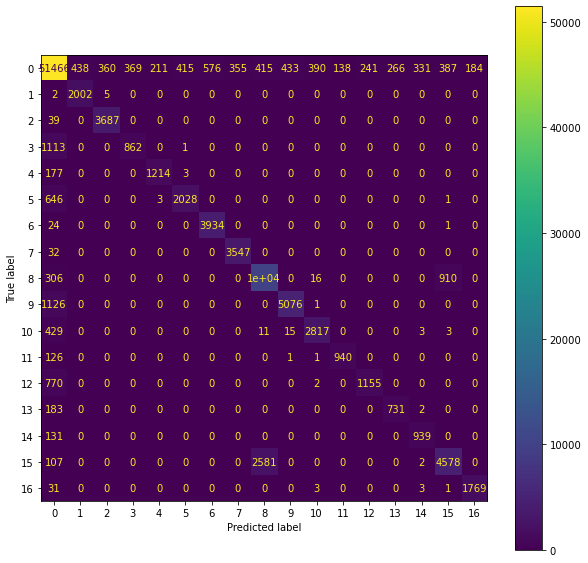

In [19]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(clf.score(X1, Y1))
print(classification_report(Y1, clf.predict(X1)))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X1, Y1, ax=ax)
plt.show()

0.7894887039239001
              precision    recall  f1-score   support

           0       0.81      0.90      0.85     10776
           1       1.00      0.96      0.98        46
           2       0.82      0.73      0.77      1428
           3       0.74      0.55      0.63       830
           4       0.67      0.82      0.74       237
           5       0.88      0.60      0.72       483
           6       0.92      0.77      0.84       730
           7       1.00      0.89      0.94        28
           8       0.95      0.99      0.97       478
           9       1.00      0.70      0.82        20
          10       0.73      0.70      0.71       972
          11       0.67      0.83      0.74      2455
          12       0.78      0.78      0.78       593
          13       0.98      0.97      0.98       205
          14       0.82      0.25      0.38      1265
          15       0.71      0.04      0.07       386
          16       1.00      0.66      0.79        93

    acc

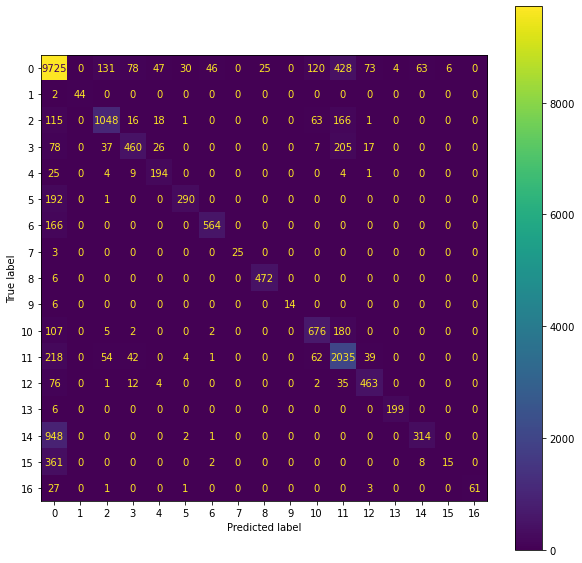

In [25]:
print(clf.score(X2, Y2))
print(classification_report(Y2, clf.predict(X2)))
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X2, Y2, ax=ax)
plt.show()